In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gamma
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Personal imports
sys.path.append("{}/../../../utils".format(os.getcwd()))
from glm_utils import eventsMatrix, extract_predictions_r2
from surface_utils import load_surface, make_surface_image
from pycortex_utils import draw_cortex, set_pycortex_config_file,load_surface_pycortex

In [2]:
main_dir = '/Users/uriel/disks/meso_shared'
code_dir = '/Users/uriel/disks/meso_H/projects'
project_dir = 'RetinoMaps'
subject = 'sub-12'
format_ = 'fsnative'

# Particioants

In [ ]:
participants_fn = '{}/{}/participants.tsv'.format(main_dir, project_dir)
participants = pd.read_table(participants_fn)

In [ ]:
print(participants.age.mean())
print(participants.age.std())
print(participants.sex.value_counts())


# Flat Map

In [ ]:
fn_170k = '/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-02/170k/final_stats/results/sub-02_final-stats.dtseries.nii'
results_170k = load_surface_pycortex(brain_fn=fn_170k)  
data_170k = results_170k['data_concat']
fake_data_170k = np.zeros_like(dadata_170kta[1,:])


In [ ]:
fn_fsnative_L = '/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-03/fsnative/final_stats/results/sub-03_hemi-L_final-stats.func.gii'
fn_fsnative_R = '/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-03/fsnative/final_stats/results/sub-03_hemi-R_final-stats.func.gii'

results_fsnative = load_surface_pycortex(L_fn=fn_fsnative_L, R_fn=fn_fsnative_R)
data_fsnative = results_fsnative['data_concat']
fake_data_fsnative = np.zeros_like(data_fsnative[1,:])


In [ ]:
param = {'subject':subject,'xfmname':None,'data': data_fsnative[1,:], 'cmap': 'stats_colors', 'alpha': fake_data_fsnative, 
             'vmin': 0, 'vmax': 1, 'cbar': None, 'cmap_steps': 255,
             'cortex_type': 'VertexRGB','description': 'final map','with_borders':False,
             'curv_brightness': 0.1, 'curv_contrast': 0.25, 'add_roi': False,
             'cbar_label': '', 'with_labels': False}



a = draw_cortex(**param)
plt.savefig('/Users/uriel/Downloads/fsnative_flat.pdf')

# pRF prediction bold

In [6]:
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_bold.func.gii'.format(bold_dir, subject)
bold_img,bold_data = load_surface(fn = bold_fn)

In [9]:
prf_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/fit/'.format(main_dir, project_dir,subject,format_)
prf_pred_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-pred_css.func.gii'.format(prf_dir, subject)
prf_pred_img, prf_pred_data = load_surface(fn = prf_pred_fn)

In [22]:
x_idx, y_idx, size_idx, r2_idx = 0,1,2,8
prf_fit_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-fit_css.func.gii'.format(prf_dir, subject)
prf_fit_img, prf_fit_data = load_surface(fn = prf_fit_fn)

In [15]:
prf_fit_data.shape

(10, 143728)

In [16]:
["prf_rsq", "prf_ecc", "polar_real", "polar_imag", "prf_size", "amplitude", "baseline", "prf_x", "prf_y", "hrf_1", "hrf_2", "prf_n", "prf_loo_r2"],

(['prf_rsq',
  'prf_ecc',
  'polar_real',
  'polar_imag',
  'prf_size',
  'amplitude',
  'baseline',
  'prf_x',
  'prf_y',
  'hrf_1',
  'hrf_2',
  'prf_n',
  'prf_loo_r2'],)

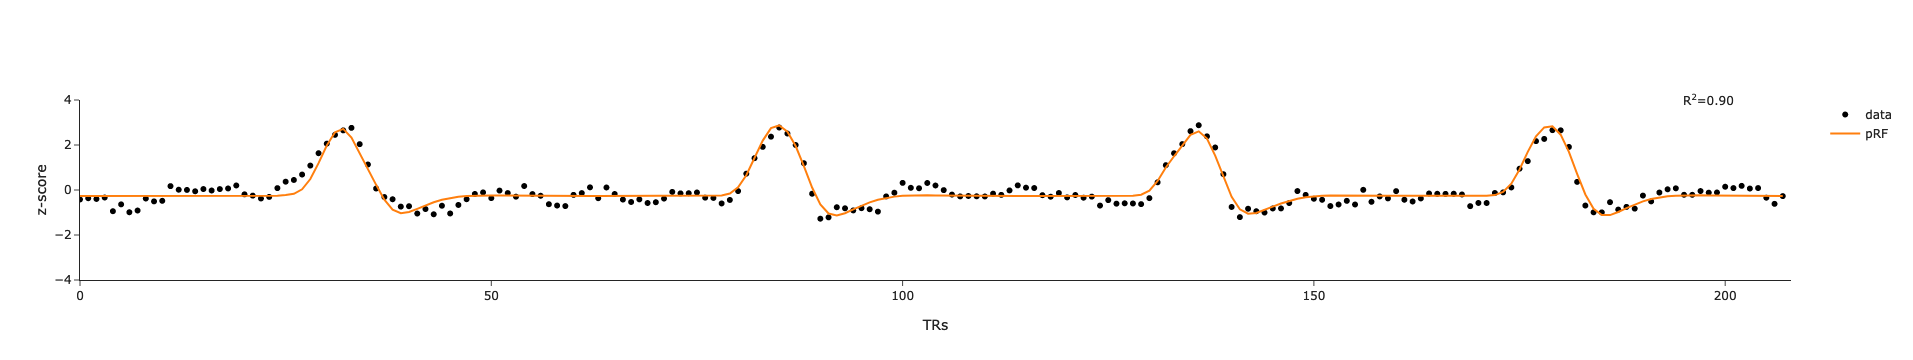

In [23]:
# plot best voxel for left hemisphere
max_indices = np.nanargmax(prf_fit_data[r2_idx,:])
# # num_vert = 25023
num_vert = max_indices
num_vert_r2 = num_vert # - 50
fig1 = go.Figure()
# plot data time series
fig1.add_trace(go.Scatter(y=bold_data[:,num_vert],
                         name='data', 
                         mode='markers', 
                          line=dict(color='black') 
                         ))

# plot pRF prediction
fig1.add_trace(go.Scatter(y=prf_pred_data[:,num_vert_r2],
                         name='pRF'))


fig1.add_annotation(text='R<sup>2</sup>={:1.2f}'.format(prf_fit_data[r2_idx,num_vert_r2]),  
                    x=198,  
                    y=4,
                    showarrow=False
                   )

fig1.update_layout(template='simple_white', 
                   # title = '{} vertex time series for {} noise model'.format(num_vert,noise_model_2), 
                   xaxis_title = 'TRs', 
                   yaxis_title = 'z-score', 
                   showlegend= True,
                   height=350, 
                   yaxis=dict(title_standoff=0))

fig1.update_xaxes(range=[0,bold_data.shape[0]])
# fig1.update_xaxes(range=[0,50])

fig1.update_yaxes(range=[-4,4])
fig1.write_image('/Users/uriel/Downloads/sdfr.pdf', width=1000, height=300)

fig1.show()

In [19]:
np.nanargmax(prf_fit_data[r2_idx,:])

1971

In [20]:
prf_fit_data[r2_idx,1971]

0.7233471

# pRF stimulation

In [ ]:
task = 'pRF'
session = 'ses-01'
event_dir = '{}/{}/{}/{}/func/'.format(main_dir,project_dir,subject,session)
event_file = glob.glob("{}/{}_{}_task-{}_run-*_events.tsv".format(event_dir,subject,session,task))
events = pd.read_table(event_file[0])

In [ ]:
task_periode = np.where(events['bar_direction'] != 9, 1, 0)


In [ ]:
fig2 = go.Figure()
# plot data time series
fig2.add_trace(go.Scatter(y=task_periode,
                          line=dict(color='#ff7f0e',
                                    width=4)))
fig2.update_xaxes(visible=False)
fig2.update_yaxes(visible=False)
fig2.update_layout(template='simple_white')
fig2.write_image('/Users/uriel/Downloads/prf_stim.pdf', width=600, height=300)
fig2.show()

# HRF

In [ ]:
def hrf(t):
    a1 = 6
    a2 = 12
    b1 = 0.9
    b2 = 0.9
    hrf_values = (gamma.pdf(t, a1, scale=b1) - 0.35 * gamma.pdf(t, a2, scale=b2))
    hrf_values /= hrf_values.sum()

    return hrf_values

time = np.arange(0, 30, 0.1)
hrf_result = hrf(time)

In [ ]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(y=hrf_result, 

                         line=dict(color='#ff7f0e', width=4)))

fig3.update_layout(template='simple_white',
                  showlegend=False,
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, ticks='', showline=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, ticks='', showline=False))





fig3.write_image('/Users/uriel/Downloads/hrf.pdf', width=600, height=300)
fig3.show()

# Receptieve field

In [ ]:
def compressive_spatial_summation(x, size, position, exponent):
    return np.exp(-((x - position) / size)**exponent)


size = 2  
position = 3  
exponent = 2 

x = np.linspace(-1, 7, 100)
y = compressive_spatial_summation(x, size, position, exponent)

In [ ]:
fig4 = go.Figure()

fig4.add_trace(go.Scatter(x=x, 
                         y=y,

                         line=dict(color='#ff7f0e', width=4)))

fig4.update_layout(template='simple_white',
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, ticks='', showline=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, ticks='', showline=False))





fig4.write_image('/Users/uriel/Downloads/css.pdf', width=600, height=300)
fig4.show()

# pRF position

In [ ]:
def gaus_2d(gauss_x, gauss_y, gauss_sd, screen_side, grain=200):
    """
    Generate 2D gaussian mesh
    
    Parameters
    ----------
    gauss_x : mean x gaussian parameter in dva (e.g. 1 dva)
    gauss_y : mean y gaussian parameter in dva (e.g. 1 dva)
    gauss_sd : sd gaussian parameter in dva (e.g. 1 dva)
    screen_side : mesh screen side (square) im dva (e.g. 20 dva from -10 to 10 dva)
    grain : grain resolution of the mesh in pixels (default = 100 pixels)
    
    Returns
    -------
    x : linspace x of the mesh
    y : linspace x of the mesh
    z : mesh_z values (to plot)
    
    """
    x = np.linspace(-screen_side/2, screen_side/2, grain)
    y = np.linspace(-screen_side/2, screen_side/2, grain)
    mesh_x, mesh_y = np.meshgrid(x,y) 
    
    gauss_z = 1./(2.*np.pi*gauss_sd*gauss_sd)*np.exp(-((mesh_x-gauss_x)**2./(2.*gauss_sd**2.)+(mesh_y-gauss_y)**2./(2.*gauss_sd**2.)))
    return x, y, gauss_z

In [ ]:
screen_side = 8.9*2
x,y,z = gaus_2d(gauss_x=prf_fit_data[x_idx,num_vert], gauss_y=prf_fit_data[y_idx,num_vert], 
                gauss_sd=prf_fit_data[size_idx,num_vert], screen_side=screen_side)


fig=go.Figure()
fig.add_trace(go.Heatmap(x=x, y=y, z=z,colorscale='viridis', showscale=False))

# Visual designe Sac/Pur Loc

L'image a été enregistrée sous le nom 'output_image.png' avec la taille finale spécifiée.


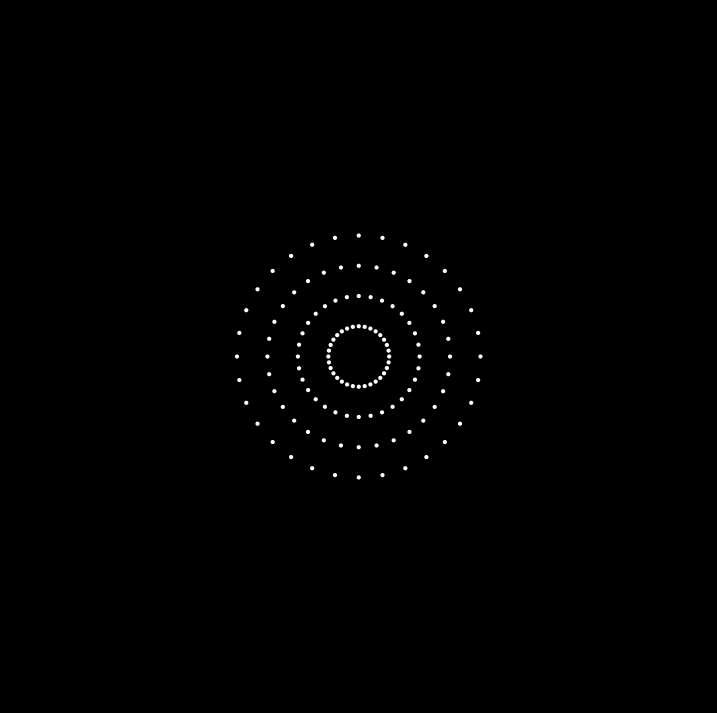

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def create_image(eccentricities_degrees, num_directions=32, circle_size=0.02, figure_size=(4, 4), final_size=(8.2, 14.58)):
    # Créer une figure et un axe avec une taille personnalisée
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Définir le fond noir
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Définir les coordonnées du centre
    center = np.array([0.5, 0.5])

    # Conversion des excentricités de degrés en radians
    eccentricities_radians = np.radians(eccentricities_degrees)

    # Créer les cercles avec des ronds blancs pour chaque excentricité
    for eccentricity in eccentricities_radians:
        for direction in range(num_directions):
            angle = (2 * np.pi / num_directions) * direction
            x = center[0] + eccentricity * np.cos(angle)
            y = center[1] + eccentricity * np.sin(angle)

            # Dessiner le cercle blanc
            circle = plt.Circle((x, y), circle_size, color='white')
            ax.add_artist(circle)

    # Paramètres d'affichage
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    # Sauvegarder l'image avec la taille finale en centimètres
    fig.savefig('/Users/uriel/Downloads/cercles.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Excentricités en degrés
eccentricities_degrees = [10, 7.5, 5, 2.5]

# Taille du cercle réduite et taille de la figure personnalisée
create_image(eccentricities_degrees, circle_size=0.002, figure_size=(9, 9))

# Afficher le message de confirmation
print("L'image a été enregistrée sous le nom 'output_image.png' avec la taille finale spécifiée.")


# GLM

In [46]:
# task = 'PurLoc'
# task = 'SacLoc'
# task = 'SacVELoc'
task = 'PurVELoc'

In [47]:
bold_glm_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_glm_fn = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_loo-1_bold.func.gii'.format(bold_dir, subject,task)
bold_glm_img,bold_glm_data = load_surface(fn = bold_glm_fn)

In [48]:
glm_dir ='{}/{}/derivatives/pp_data/{}/{}/glm/glm_fit/'.format(main_dir, project_dir,subject,format_)
glm_pred_fn = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_loo-1_glm-pred.func.gii'.format(glm_dir, subject,task)
glm_pred_img, glm_pred_data = load_surface(fn = glm_pred_fn)

In [49]:
glm_stats_dir ='{}/{}/derivatives/pp_data/{}/{}/glm/glm_derivatives/'.format(main_dir, project_dir,subject,format_)
glm_fit_fn = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_loo-1_glm-stats.func.gii'.format(glm_stats_dir, subject,task)
glm_fit_img, glm_fit_data = load_surface(fn = glm_fit_fn)
slope_idx, intercept_idx, rvalue_idx, pvalue_idx, stderr_idx  = 0,1,2,3,4

In [50]:
session = 'ses-02'
event_dir = '{}/{}/{}/{}/func/'.format(main_dir,project_dir,subject,session)
event_file = glob.glob("{}/{}_{}_task-{}_run-*_events.tsv".format(event_dir,subject,session,task))
events = pd.read_table(event_file[0])

In [51]:
if task == 'PurLoc': 
    idx = 2
    task_name = 'Pursuit'
    color = '#E377C2'
    task_periode = np.where(events['trial_type'] == idx, 1, np.nan)
elif task == 'PurVELoc': 
    idx = 2
    task_name = 'Pursuit'
    color = '#E377C2'
    task_periode = np.where(events['eyemov_vis_end'] == idx, 1, np.nan)
elif task == 'SacLoc': 
    idx = 1
    task_name = 'Saccad'
    color = '#8C564B'
    task_periode = np.where(events['trial_type'] == idx, 1, np.nan)
elif task == 'SacVELoc': 
    idx = 2
    task_name = 'Saccade'
    color = '#8C564B'
    task_periode = np.where(events['eyemov_vis_end'] == idx, 1, np.nan)

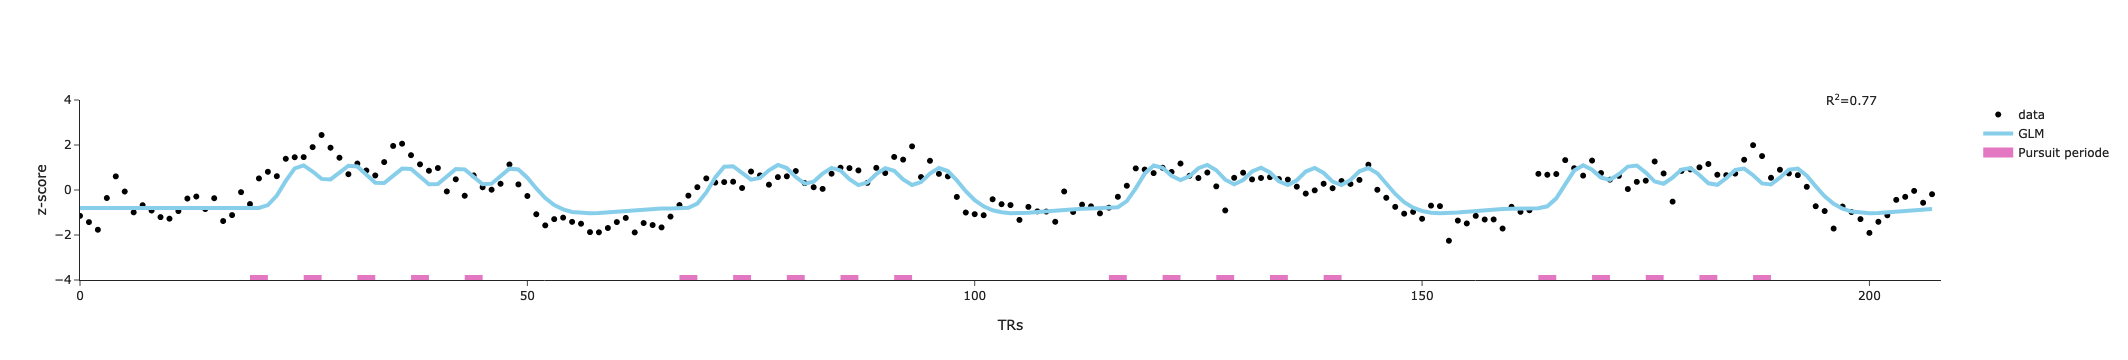

In [52]:
# plot best voxel for left hemisphere
max_indices = np.nanargmax(glm_fit_data[rvalue_idx,:])
# num_vert = 6150
num_vert = max_indices
num_vert_r2 = num_vert


fig5 = go.Figure()
# plot data time series
fig5.add_trace(go.Scatter(y=bold_glm_data[:,num_vert],
                         name='data', 
                         mode='markers', 
                          line=dict(color='black') 
                         ))

# plot pRF prediction
fig5.add_trace(go.Scatter(y=glm_pred_data[:,num_vert_r2],
                          line=dict(color='#87CEEB' ,width=4),
                          
                         name='GLM'))

# # for prf
# fig5.add_annotation(text='R<sup>2</sup>={:1.2f}'.format(prf_fit_data[rvalue_idx,num_vert_r2]),  
#                     x=198,  
#                     y=4,
#                     showarrow=False
#                    )

# for glm
fig5.add_annotation(text='R<sup>2</sup>={:1.2f}'.format(glm_fit_data[rvalue_idx,num_vert_r2]),  
                    x=198,  
                    y=4,
                    showarrow=False
                   )


fig5.add_trace(go.Scatter(y=task_periode*-4,
                          name='{} periode'.format(task_name),
                          mode='lines',
                          showlegend = True,
                          line=dict(width=10, color=color ) 
                         ))

fig5.update_layout(template='simple_white', 
                   # title = '{} vertex time series for {} noise model'.format(num_vert,noise_model_2), 
                   xaxis_title = 'TRs', 
                   yaxis_title = 'z-score', 
                   showlegend= True,
                   # height=350, 
                   yaxis=dict(title_standoff=0))

fig5.update_xaxes(range=[0,bold_glm_data.shape[0]])

fig5.update_yaxes(range=[-4,4])
fig5.write_image('/Users/uriel/Downloads/glm_{}.pdf'.format(task), width=1000, height=300)

fig5.show()

# Ecc size

In [ ]:
def prf_ecc_size_plot(data, subject, fig_height, fig_width, ecc_th=[None,None], size_th=[None,None], rsq_th=[None,None]) :
    """
    Make violins plots for pRF r2/loo_r2, ecc and size

    Parameters
    ----------
    data : A data frame with prf_rsq, prf_ecc, prf_size, prf_loo_r2, rois and subject columns
    
    Returns
    -------
    fig : the figure 
    """
    
    from maths_utils import weighted_regression, bootstrap_ci_mean
    data = data.copy()
    
    
    # fig_height, fig_width = 1080, 190
    rows, cols = 1,2

    # Replace all data outer threshold with NaN data
    data.loc[(data.prf_ecc < ecc_th[0]) | (data.prf_ecc > ecc_th[1]) | 
              (data.prf_size < size_th[0]) | (data.prf_size > size_th[1]) | 
              (data.prf_loo_r2 <=rsq_th[0])] = np.nan
    
    data = data.dropna()

    # Define colors
    roi_colors = px.colors.sequential.Sunset[:4] + px.colors.sequential.Rainbow[:]
    roi_colors =roi_colors[-7:]
    
    lines = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]

    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(lines):
        for j, roi in enumerate(line_label):
            
            # Sorting best datas
            df = data.loc[(data.subject == subject) & (data.rois == roi)]
            
            # Parametring colors
            roi_color = roi_colors[j + l * 3]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Grouping by eccentricities
            df_grouped = df.groupby(pd.cut(df['prf_ecc'], bins=np.arange(0, 17.5, 2.5)))
            df_sorted = df.sort_values('prf_ecc')
            
            ecc_mean = np.array(df_grouped['prf_ecc'].mean())
            sd_mean = np.array(df_grouped['prf_size'].mean())
            r2_mean = np.array(df_grouped['prf_loo_r2'].mean())
            

            ci = df_grouped['prf_size'].apply(lambda x: bootstrap_ci_mean(x))
            upper_bound = np.array(ci.apply(lambda x: x[1] if not np.isnan(x[1]) else np.nan))
            lower_bound = np.array(ci.apply(lambda x: x[0] if not np.isnan(x[0]) else np.nan))
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_mean, 
                                                    sd_mean, 
                                                    r2_mean,
                                                    model='linear')
            
            slope_upper, intercept_upper = weighted_regression(ecc_mean[np.where(~np.isnan(upper_bound))], 
                                                                upper_bound[~np.isnan(upper_bound)], 
                                                                r2_mean[np.where(~np.isnan(upper_bound))], 
                                                                model='linear')
            
            slope_lower, intercept_lower = weighted_regression(ecc_mean[np.where(~np.isnan(lower_bound))], 
                                                                lower_bound[~np.isnan(lower_bound)], 
                                                                r2_mean[np.where(~np.isnan(lower_bound))], 
                                                                model='linear')
            
            line = slope[0][0] * np.array(df_sorted.prf_ecc) + intercept[0]
            line_upper = slope_upper[0][0] * np.array(df_sorted.prf_ecc) + intercept_upper[0]
            line_lower = slope_lower[0][0] * np.array(df_sorted.prf_ecc) + intercept_lower[0]

            fig.add_trace(go.Scatter(x=np.array(df_sorted.prf_ecc), y=line, mode='lines', name=roi, legendgroup=roi, 
                                      line=dict(color=roi_color, width=3), showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([df_sorted.prf_ecc, df_sorted.prf_ecc[::-1]]), 
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_mean, 
                                     y=sd_mean, mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=ci.apply(lambda x: (x[1] - x[0]) / 2).tolist(), 
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                      marker=dict(color='white', 
                                                  size=8, 
                                                  line=dict(color=roi_color, 
                                                            width=3)), 
                                      showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=15-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font=dict(color=roi_color, size=12))
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF size (dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0,15], row=1, col=l+1)
        fig.update_xaxes(linewidth=2,tickwidth=2,tickfont=dict(size=14, color='black'))
        fig.update_yaxes(range=[0,15],linewidth=2,tickwidth=2,tickfont=dict(size=14, color='black'))
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template='simple_white')
        
    return fig

In [ ]:
subject = 'sub-170k'
format_ = '170k'
tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, 
                                                                project_dir, 
                                                                subject,
                                                         format_)

# data = pd.read_table('{}/{}_css-prf_derivatives.tsv'.format(tsv_dir,subject))
data = pd.read_table('{}/{}_css-prf_derivatives_group.tsv'.format(tsv_dir,subject))
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]

In [ ]:
categories_to_plot = ['vision',  'vision_and_pursuit_and_saccade']
for categorie_to_plot in categories_to_plot:
    df_categorie = data.loc[data.stats_final == categorie_to_plot]
    fig2 = prf_ecc_size_plot(df_categorie, subject, fig_height=400, fig_width=800, ecc_th=ecc_th, size_th=size_th, rsq_th=rsq_th)
    fig2.write_image("/Users/uriel/Downloads/{}_{}_ecc_size.pdf".format(subject,categorie_to_plot))
    fig2.show()

# ECC / PCM

In [ ]:
def prf_ecc_pcm_plot(data, subject, fig_height, fig_width, ecc_th=[None,None], pcm_th=[None,None], rsq_th=[None,None]) :
    """
    Make figure of ecc pcm relation 

    Parameters
    ----------
    data : A data frame with prf_rsq, prf_ecc, prf_size, prf_loo_r2, pcm, rois and subject columns
    
    Returns
    -------
    fig : the figure 
    """

    from maths_utils import weighted_regression, bootstrap_ci_mean
    data = data.copy()

    # fig_height, fig_width = 1080, 1920
    rows, cols = 1,2
    
    # Replace all data outer threshold with NaN data
    data.loc[(data.prf_ecc < ecc_th[0]) | (data.prf_ecc > ecc_th[1]) | 
              (data.pcm < pcm_th[0]) | (data.pcm > pcm_th[1]) | 
              (data.prf_loo_r2 <= rsq_th[0])] = np.nan
    
    data = data.dropna()

    # Define colors
    roi_colors = px.colors.sequential.Sunset[:4] + px.colors.sequential.Rainbow[:]

    lines = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]

    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(lines):
        for j, roi in enumerate(line_label):
            
            # Sorting best datas
            df = data.loc[(data.subject == subject) & (data.rois == roi)]
            
            # Parametring colors
            roi_color = roi_colors[j + l * 3]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Grouping by eccentricities
            df_grouped = df.groupby(pd.cut(df['prf_ecc'], bins=np.arange(0, 17.5, 2.5)))
            df_sorted = df.sort_values('prf_ecc')
            
            ecc_mean = np.array(df_grouped['prf_ecc'].mean())
            sd_mean  = np.array(df_grouped['pcm'].mean())
            r2_mean  = np.array(df_grouped['prf_loo_r2'].mean())
            
            # CI95 for each group of ecc
            ci = df_grouped['pcm'].apply(lambda x: bootstrap_ci_mean(x))
            upper_bound = np.array(ci.apply(lambda x: x[1] if not np.isnan(x[1]) else np.nan))
            lower_bound = np.array(ci.apply(lambda x: x[0] if not np.isnan(x[0]) else np.nan))
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_mean, 
                                                    sd_mean, 
                                                    r2_mean, 
                                                    model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_mean[~np.isnan(upper_bound)], 
                                                                upper_bound[~np.isnan(upper_bound)], 
                                                                r2_mean[~np.isnan(upper_bound)], 
                                                                model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_mean[~np.isnan(lower_bound)], 
                                                                lower_bound[~np.isnan(lower_bound)], 
                                                                r2_mean[~np.isnan(lower_bound)], 
                                                                model='pcm')
            
            line = 1 / (slope * np.array(df_sorted.prf_ecc)) + intercept
            line_upper = 1 / (slope_upper * np.array(df_sorted.prf_ecc)) + intercept_upper
            line_lower = 1 / (slope_lower * np.array(df_sorted.prf_ecc)) + intercept_lower

            fig.add_trace(go.Scatter(x=np.array(df_sorted.prf_ecc), 
                                      y=line, 
                                      mode='lines', 
                                      name=roi, 
                                      legendgroup=roi, 
                                      line=dict(color=roi_color, width=3), 
                                      showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([df_sorted.prf_ecc, df_sorted.prf_ecc[::-1]]), 
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_mean, 
                                      y=sd_mean, 
                                      mode='markers', 
                                      error_y=dict(type='data', array=ci.apply(lambda x: (x[1] - x[0]) / 2).tolist(), visible=True, thickness=3, width=0, color=roi_color),
                                      marker=dict(color='white', size=8, line=dict(color=roi_color,width=3)), 
                                      showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=13, 
                                              y=15-j*1.5, 
                                              text=roi, 
                                              xanchor='left',
                                              showarrow=False, 
                                              font=dict(color=roi_color, size=12))
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pCM (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0,15], row=1, col=l+1)
        fig.update_xaxes(linewidth=2,tickwidth=2,tickfont=dict(size=14, color='black'))
        fig.update_yaxes(range=[0,15],linewidth=2,tickwidth=2,tickfont=dict(size=14, color='black'))
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template='simple_white')
        
    return fig

In [ ]:
categories_to_plot = ['vision',  'vision_and_pursuit_and_saccade']
for categorie_to_plot in categories_to_plot:
    df_categorie = data.loc[data.stats_final == categorie_to_plot]
    fig2 = prf_ecc_pcm_plot(df_categorie, subject, fig_height=400, fig_width=800, ecc_th=ecc_th, pcm_th=pcm_th, rsq_th=rsq_th)
    fig2.write_image("/Users/uriel/Downloads/{}_{}_ecc_pcm.pdf".format(subject,categorie_to_plot))
    fig2.show()